In [75]:
import numpy as np
import matplotlib.pyplot as plt
from homework1_tests import *
import pandas as pd

## 逻辑回归

### 1.1 问题陈述

假设你是某大学院系的招生管理员，希望根据申请人在两门考试中的成绩来判断其被录取的概率。

* 你拥有往届申请者的历史数据，可作为训练集来训练逻辑回归模型。
* 对于每条训练样本，你都有申请人在两门考试中的分数以及最终的录取结果。
* 你的任务是构建一个分类模型，输入这两门考试的分数，输出申请人被录取的概率。


### 1.2 载入并可视化数据

首先需要加载本次任务的数据集， 路径是"./data/hw1data1.txt"

* 定义函数 然后调用 或者 直接写代码 把数据加载到 `X_train` 与 `y_train` 变量中

  * `X_train`：每位学生在两门考试中的分数
  * `y_train`：对应的录取结果

    * 当学生被录取时，`y_train = 1`
    * 当学生未被录取时，`y_train = 0`
  * `X_train` 和 `y_train` 都是 NumPy 数组。


In [51]:
# TODO 1. 读取数据，X_train存特征, y_train存标签(分类）
data = pd.read_csv("./data/hw1data1.txt", header=None)

X_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

assert type(X_train) == np.ndarray and X_train.shape==(100,2) and type(y_train) == np.ndarray and y_train.shape==(100,)#

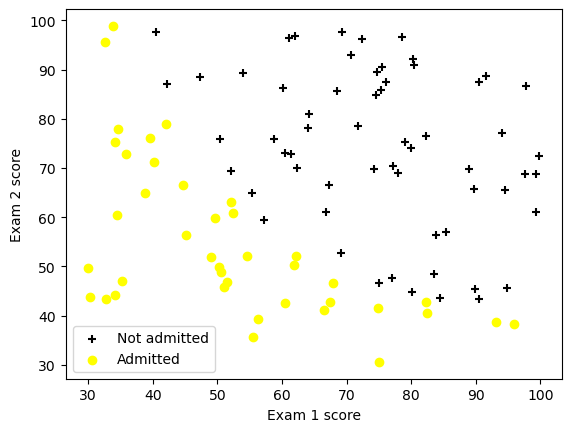

In [52]:
# TODO 2. 可视化数据：横轴是第一次考试的分数，纵轴是第二次考试的分数，被录取类和未被录取类用不同的标记
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
# plt.show()
# 紫不录取 黄录取

# # 模拟老师
y_train_bool = y_train.astype(bool)
plt.scatter(X_train[y_train_bool, 0], X_train[y_train_bool, 1],c = 'black', label = 'Not admitted',marker = '+')
plt.scatter(X_train[~y_train_bool, 0], X_train[~y_train_bool, 1], c='yellow', label = 'Admitted')
plt.legend()
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.show()


### 1.3  Sigmoid（S 型）函数

回顾逻辑回归模型的表达式：

$$
f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)
$$

其中 $g$ 为 **Sigmoid 函数**，定义为：

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

接下来我们先实现 Sigmoid 函数，供后续练习调用。
请完成 `sigmoid` 函数的代码，实现

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

注意：

* 这里的 `z` 不一定只是一个数字，也可能是一个数字数组；
* 如果输入是数组，需要对数组中的每个元素都应用 Sigmoid 函数。


In [73]:
# TODO 3. 实现sigmoid函数
def sigmoid(z):
    return 1/(1+np.exp(-z))


In [74]:
# 运行此代码测试实现是否通过所有测试, 正常会显示All tests passed!
sigmoid_test(sigmoid)

All tests passed!


### 1.4 请根据下式完成 `compute_cost` 函数的代码。

回忆一下，逻辑回归的总体代价函数定义为

$$
J(\mathbf{w},b)=\frac{1}{m}\sum_{i=0}^{m-1}
\Bigl[\,
\text{loss}\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\,y^{(i)}\bigr)
\Bigr]
\tag{1}
$$

其中

* $m$ —— 训练样本数量

* $\text{loss}\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\,y^{(i)}\bigr)$ 是单个样本的损失，定义为

  $$
  \text{loss}\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\,y^{(i)}\bigr)
  =-\,y^{(i)}\log\!\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)})\bigr)
   -\bigl(1-y^{(i)}\bigr)\,
     \log\!\bigl(1-f_{\mathbf{w},b}(\mathbf{x}^{(i)})\bigr)
  \tag{2}
  $$

* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ —— 模型对第 $i$ 个样本的预测概率，
  $y^{(i)}$ 是其真实标签。

* 预测值计算过程

  $$
    f_{\mathbf{w},b}(\mathbf{x}^{(i)})=g\bigl(\mathbf{w}\cdot\mathbf{x}^{(i)}+b\bigr)
  $$

  这里的 $g$ 为 **Sigmoid** 函数。实现时，通常先求中间量

  $$
    z_{\mathbf{w},b}(\mathbf{x}^{(i)})
    =\mathbf{w}\cdot\mathbf{x}^{(i)}+b
    =w_0x^{(i)}_0+\dots+w_{\,n-1}x^{(i)}_{\,n-1}+b
  $$

  （$n$ 为特征数），然后再计算
  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})=g\bigl(z_{\mathbf{w},b}(\mathbf{x}^{(i)})\bigr)$。



In [26]:
# TODO 4 实现compute_cost函数
def compute_cost(X, y, w, b, *argv):
    """
    计算整个训练集的代价（cost）

    参数
    ----
    X : ndarray, 形状 (m, n)
        训练数据，m 行 n 列（m 个样本，n 个特征）
    y : ndarray, 形状 (m,)
        目标值 / 标签
    w : ndarray, 形状 (n,)
        模型参数向量
    b : float
        模型的偏置项
    *argv :
        预留参数（当前未使用），用于与后续含正则化版本兼容

    返回
    ----
    total_cost : float
        计算得到的平均代价
    """
    f = sigmoid(np.dot(X, w) + b)
    m = X.shape[0]
    cost = np.sum(y * np.log(f) + (1 - y) * np.log(1 - f)) / m
    return -cost


In [27]:
# 运行此代码测试实现是否通过所有测试, 正常会显示All tests passed!
compute_cost_test(compute_cost)

All tests passed!


### 1.5 逻辑回归的梯度

在本节中，你将实现逻辑回归的梯度计算。

回忆**梯度下降**算法的迭代形式：

$$
\begin{align*}
&\text{重复，直到收敛：}\ \{\\[4pt]
&\quad b \;:=\; b \;-\; \alpha\,\frac{\partial J(\mathbf{w},b)}{\partial b} \\[6pt]
&\quad w_j \;:=\; w_j \;-\; \alpha\,\frac{\partial J(\mathbf{w},b)}{\partial w_j}
\quad\text{（对 } j=0,\dots,n-1\text{）}\\[4pt]
&\}
\end{align*}
\tag{1}
$$

其中

* $\alpha$ 是学习率
* $J(\mathbf{w},b)$ 是成本函数
* $\dfrac{\partial J}{\partial b},\ \dfrac{\partial J}{\partial w_j}$ 是对偏置 $b$ 和各权重 $w_j$ 的偏导数。

请根据下列公式 (2) 和 (3)，完成 `compute_gradient` 函数，计算
$\dfrac{\partial J(\mathbf{w},b)}{\partial w}$ 和 $\dfrac{\partial J(\mathbf{w},b)}{\partial b}$。

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}
  = \frac{1}{m}\sum_{i=0}^{m-1}
    \Bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Bigr) \tag{2}
$$

$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}
  = \frac{1}{m}\sum_{i=0}^{m-1}
    \Bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Bigr)\,x^{(i)}_{j}
  \tag{3}
$$

* $m$ 为训练集中样本的数量
* $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ 是模型对第 $i$ 个样本的预测值，
  $y^{(i)}$ 是该样本的真实标签。


In [28]:
# TODO 5 实现compute_gradient函数
def compute_gradient(X, y, w, b, *argv):
    """
    计算逻辑回归的梯度
    参数
    ------
    X : ndarray, 形状 (m, n)
        输入特征矩阵，m 行 n 列（m 个样本，每样本 n 个特征）
    y : ndarray, 形状 (m,)
        目标值（标签）向量
    w : ndarray, 形状 (n,)
        模型权重参数
    b : float
        模型偏置参数
    *argv :
        预留参数，当前未使用，仅为与后续含正则化版本接口保持一致

    返回
    ------
    dj_db : float
        成本函数对偏置 b 的梯度

    dj_dw : ndarray, 形状 (n,)
        成本函数对权重 w 的梯度
    """
    # 注意：按 dj_db, dj_dw的顺序返回！
    f = sigmoid(np.dot(X, w) + b)
    m = X.shape[0]
    dj_db = np.sum(f - y) / m
    dj_dw = np.dot(X.T, f - y) / m
    return dj_db, dj_dw


In [29]:
#  单个例子调用
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db:', dj_db)
print('dj_dw:', dj_dw.tolist())

#  运行此代码测试实现是否通过所有测试, 正常会显示All tests passed!
compute_gradient_test(compute_gradient)

dj_db: -0.5999999999991071
dj_dw: [-44.831353617873795, -44.37384124953977]
All tests passed!


### 1.6 使用梯度下降学习参数
* 检查梯度下降是否正常工作的一个好方法，是观察 $J(\mathbf{w},b)$ 的数值是否在每一步都在下降。

In [76]:
# TODO： 6. 执行梯度下降关键步骤：参数更新，在函数内补充代码

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_):
    """
    执行 **批量梯度下降** 来学习模型参数。
    通过学习率 alpha 进行 num_iters 次梯度更新以优化 θ (w, b)。

    参数
    ------
    X : ndarray, 形状 (m, n)
        训练特征矩阵，m 个样本，n 个特征
    y : ndarray, 形状 (m,)
        目标值 / 标签向量
    w_in : ndarray, 形状 (n,)
        模型权重参数的初始值
    b_in : float
        模型偏置参数的初始值
    cost_function : callable
        计算代价 J 的函数
    gradient_function : callable
        计算梯度 (dj_dw, dj_db) 的函数
    alpha : float
        学习率
    num_iters : int
        梯度下降的迭代次数
    lambda_ : float
        正则化常数 λ

    返回
    ------
    w_in : ndarray, 形状 (n,)
        迭代结束后的权重参数
    b_in : float
        迭代结束后的偏置参数
    J_history : list[float]
        每次迭代记录的代价 J（便于绘图）
    w_history : list[ndarray]
        部分迭代记录下来的 w（便于可视化收敛过程）
    """

    # 训练样本数量
    m = len(X)

    # 用于保存每次迭代的代价 J 和 w（主要用于后续绘图）
    J_history = []
    w_history = []

    for i in range(num_iters):

        # TODO: 计算梯度并更新参数
        dj_db,dj_dw = gradient_function(X, y, w_in, b_in)

        # TODO：使用学习率 alpha 按梯度更新参数 w 和 b
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # 记录每次迭代的代价 J
        if i < 100000:      # 防止资源耗尽
            cost = cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # 每进行总迭代数的 1/10 输出一次代价（若迭代次数 < 10，则每次都输出）
        if i % math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    # 返回最终 w、b 以及 J、w 的历史记录，便于绘图
    return w_in, b_in, J_history, w_history


In [31]:
# 运行梯度下降

# 初始参数设置
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

# 迭代次数和学习率设置
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b,
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.85   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


### 1.7 绘制决策边界

现在，我们将使用梯度下降所得的最终参数来绘制线性决策边界。如果你之前的实现都正确，应该会看到下个单元格所示的类似结果。


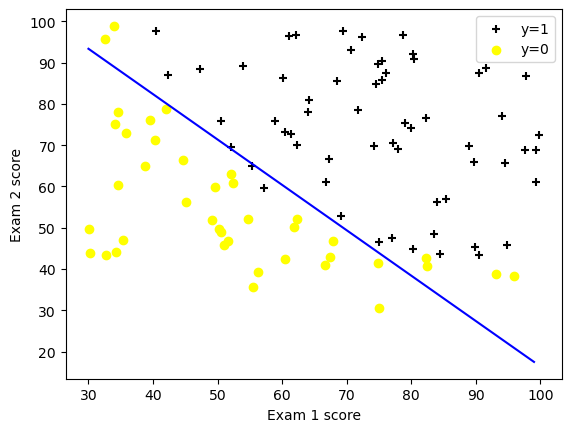

In [43]:
# TODO 7. 画决策边界
y_train_bool = y_train.astype(bool)
plt.scatter(X_train[y_train_bool, 0], X_train[y_train_bool, 1],c = 'black', label = 'y=1',marker = '+')
plt.scatter(X_train[~y_train_bool, 0], X_train[~y_train_bool, 1], c='yellow', label = 'y=0')
plt.legend()
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
x0 = np.arange(30,100)
x1 = -(b + w[0] * x0) / w[1]
plt.plot(x0, x1, c = 'blue')
plt.show()


### 1.8 评估逻辑回归模型

我们可以通过查看训练集中模型的预测效果来评估已学习参数的质量。

接下来请你完成下面的 `predict` 函数，实现模型预测。


请完成 `predict` 函数，使其在给定数据集以及已学习到的参数向量 $w$ 和 $b$ 时，输出预测结果 `1` 或 `0`。

步骤说明：

1. **计算模型预测值**

   * 对每个样本 $x^{(i)}$，先计算

     $$
       f(x^{(i)}) = g\bigl(w \cdot x^{(i)} + b\bigr)
     $$

     其中 $g$ 为 Sigmoid 函数。这部分你在前面已经实现过。

2. **将预测值解释为概率**

   * $f(x^{(i)})$ 被视为在参数 $w,b$ 下，给定输入 $x^{(i)}$ 时 $y^{(i)}=1$ 的概率。

3. **根据概率给出最终分类**

   * 如果 $f(x^{(i)}) \ge 0.5$，则预测 $y^{(i)}=1$
   * 如果 $f(x^{(i)}) < 0.5$，则预测 $y^{(i)}=0$

按照此逻辑实现 `predict` 即可。

In [44]:
# TODO: 8 实现预测
def predict(X, w, b):
    """
    使用学习到的逻辑回归参数 w、b 预测样本标签（0 或 1）

    参数
    ------
    X : ndarray, 形状 (m, n)
        特征矩阵，m 个样本，每个样本 n 个特征
    w : ndarray, 形状 (n,)
        模型权重参数
    b : float
        模型偏置参数

    返回
    ------
    p : ndarray, 形状 (m,)
        对 X 的预测结果，使用 0.5 作为分类阈值
    """
    f = sigmoid(np.dot(X, w) + b)
    f[f >= 0.5] = 1
    f[f < 0.5] = 0
    return f


In [45]:
# 测试预测的代码
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

#  运行此代码测试实现是否通过所有测试, 正常会显示All tests passed!
predict_test(predict)

Output of predict: shape (4,), value [0. 1. 1. 1.]
All tests passed!


In [46]:
# 计算在训练集上 预测分类的准确率，正常实现应该是92%
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


## 2 - 正则化逻辑回归

在本部分练习中，你将实现**正则化逻辑回归**，用来预测一家芯片制造厂生产的微芯片能否通过质量检验（QA）。在 QA 过程中，每块芯片都会经过多项测试，以确保其工作正常。

<a name="3.1"></a>

### 2.1 问题陈述

假设你是这家工厂的产品经理，手头有一些微芯片在两项不同测试中的测量结果。

* 你希望根据这两项测试来决定芯片应被**接受**还是**拒收**。
* 为了做出决策，你拥有过往芯片的历史测试数据，可用来训练一个逻辑回归模型。


### 2.2 载入并可视化数据

与前面练习类似，我们先加载本任务的数据集并进行可视化。

* 数据集的路径：./data/hw2data2.txt

  * `X_train`：两项测试的结果（特征）
  * `y_train`：QA 检验结果

    * 若芯片通过检验，则 `y_train = 1`
    * 若芯片未通过检验，则 `y_train = 0`
  * `X_train` 与 `y_train` 都是 NumPy 数组。


In [53]:
# TODO: 9 加载数据
data = pd.read_csv("./data/hw1data2.txt", header=None)

X_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

assert X_train.shape==(118,2) and y_train.shape==(118,)

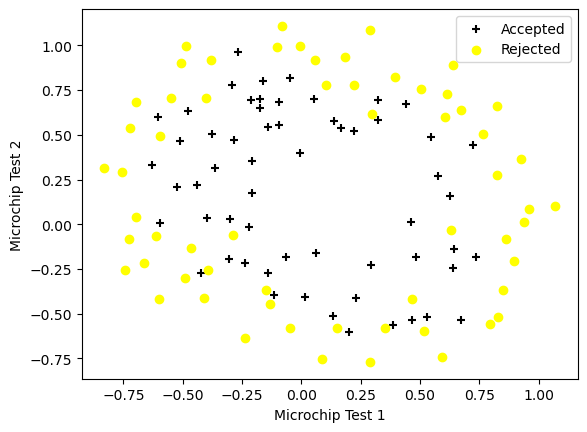

In [55]:
# TODO:10 数据可视化，得到如下图形
y_train_bool = y_train.astype(bool)
plt.scatter(X_train[y_train_bool, 0], X_train[y_train_bool, 1],c = 'black', label = 'Accepted',marker = '+')
plt.scatter(X_train[~y_train_bool, 0], X_train[~y_train_bool, 1], c='yellow', label = 'Rejected')
plt.legend()
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.show()


如上图所示，无法用一条直线将数据集中的正、负样本分开。因此，直接应用普通逻辑回归在该数据集上表现不会理想，因为逻辑回归只能找到线性的决策边界。

### 2.3 特征映射

为了更好地拟合数据，可以为每个样本生成更多的特征。在给定的 `map_feature` 函数中，我们把原始特征 $x_1, x_2$ 映射成包含所有不超过 6 次的多项式项：

$$
\mathrm{map\_feature}(x)=
\begin{bmatrix}
x_1\\
x_2\\
x_1^2\\
x_1x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1x_2^5\\
x_2^6
\end{bmatrix}
$$

如此映射后，原本只有两维（两项 QA 测试分数）的特征向量被扩展成了 27 维。

* 用这个高维特征训练的逻辑回归分类器能够学习到更复杂的决策边界，在二维平面中表现为非线性曲线。
* `map_feature` 函数已在下个单元格内实现，可直接调用。


In [56]:
def map_feature(X1, X2):
    """
    多项式特征组合
    """
    X1 = np.atleast_1d(X1) # 将标量输入转换为一维数组。
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.column_stack(out)

In [57]:
print("data的原始形状:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("特征映射后的data的形状:", mapped_X.shape)

data的原始形状: (118, 2)
特征映射后的data的形状: (118, 27)


In [58]:
# 看看原始数据 和 特征映射后的数据
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


虽然特征映射能让分类器更灵活，但也更容易 **过拟合**。接下来你将实现**正则化逻辑回归**来拟合数据，并亲自体会正则化如何缓解过拟合问题。


### 2.4 正则化逻辑回归的代价函数

在本节中，你将实现 **正则化逻辑回归** 的代价函数。

对于正则化逻辑回归，代价函数形式为

$$
J(\mathbf{w},b)=
\frac{1}{m}\sum_{i=0}^{m-1}
\Bigl[
-y^{(i)}\log f_{\mathbf{w},b}(\mathbf{x}^{(i)})
-\bigl(1-y^{(i)}\bigr)\log\!\bigl(1-f_{\mathbf{w},b}(\mathbf{x}^{(i)})\bigr)
\Bigr]
\;+\;
\frac{\lambda}{2m}\sum_{j=0}^{n-1} w_j^{2}
$$

与前面未加正则化时的代价函数相比

$$
J(\mathbf{w},b)=
\frac{1}{m}\sum_{i=0}^{m-1}
\Bigl[
-y^{(i)}\log f_{\mathbf{w},b}(\mathbf{x}^{(i)})
-\bigl(1-y^{(i)}\bigr)\log\!\bigl(1-f_{\mathbf{w},b}(\mathbf{x}^{(i)})\bigr)
\Bigr]
$$

两者的区别在于额外的 **正则化项**

$$
\frac{\lambda}{2m}\sum_{j=0}^{n-1} w_j^{2}
$$

请注意，**偏置项 $b$ 不进行正则化**。


请完成下面的 `compute_cost_reg` 函数，实现对参数向量 $w$ 计算并加入以下正则化项：

$$
\frac{\lambda}{2m} \sum_{j=0}^{n-1} w_j^{2}
$$

In [65]:
# TODO 11： 完成正则化的损失计算
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    计算带正则化项的总体代价

    参数
    ------
    X : ndarray, 形状 (m, n)
        输入特征矩阵，m 个样本，n 个特征
    y : ndarray, 形状 (m,)
        目标值 / 标签向量
    w : ndarray, 形状 (n,)
        模型权重参数
    b : float
        模型偏置参数
    lambda_ : float
        正则化强度 λ

    返回
    ------
    total_cost : float
        含正则化项的总代价
    """
    f = sigmoid(np.dot(X, w) + b)
    m = X.shape[0]
    cost1 = -np.sum(y * np.log(f) + (1 - y) * np.log(1 - f)) / m
    cost2 = lambda_ * np.sum(w ** 2) / (2 * m)
    return cost1 + cost2


In [66]:
# 运行下面代码 测试实现是否正确
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

# 测试
compute_cost_reg_test(compute_cost_reg)

Regularized cost : 0.6618252552483951
All tests passed!


### 2.5 正则化逻辑回归的梯度

在本节中，你将实现**正则化逻辑回归**的梯度计算。

正则化后代价函数 $J(\mathbf{w},b)$ 的梯度分为两部分：

* 对偏置项 $b$ 的偏导数是一个标量
* 对权重向量 $\mathbf w$ 的偏导数仍是与 $\mathbf w$ 同形状的向量，其第 $j$ 个分量如下

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}
  =\frac{1}{m}\sum_{i=0}^{m-1}\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)})-y^{(i)}\bigr)
$$

$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}
   =\Bigl[\frac{1}{m}\sum_{i=0}^{m-1}
          \bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)})-y^{(i)}\bigr)
          x_j^{(i)}\Bigr]
    +\frac{\lambda}{m}\,w_j,
    \quad j=0,\dots ,n-1
$$



#### 与**无正则化**情形的比较

未加正则化时，你已经实现过的梯度为

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}
  =\frac{1}{m}\sum_{i=0}^{m-1}\bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)})-y^{(i)}\bigr)
\tag{2}
$$

$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}
  =\frac{1}{m}\sum_{i=0}^{m-1}
   \bigl(f_{\mathbf{w},b}(\mathbf{x}^{(i)})-y^{(i)}\bigr)\,x_j^{(i)}
\tag{3}
$$

可以看到：

* **对 $b$ 的梯度两种情况完全相同**。
* 差异在于 $\displaystyle\frac{\partial J}{\partial w_j}$ 的最后一项

  $$
    \frac{\lambda}{m}\,w_j,\quad j=0,\dots ,n-1
  $$

  这正是正则化带来的额外“收缩”项，用来抑制权重过大、防止过拟合。


In [67]:
# TODO 12: 实现梯度计算
def compute_gradient_reg(X, y, w, b, lambda_ = 1):
    """
    计算带正则化项的逻辑回归梯度

    参数
    ------
    X : ndarray, 形状 (m, n)
        输入特征矩阵，m 个样本，n 个特征
    y : ndarray, 形状 (m,)
        目标值（标签）向量
    w : ndarray, 形状 (n,)
        模型权重参数
    b : float
        模型偏置参数
    lambda_ : float
        正则化常数 λ

    返回
    ------
    dj_db : float
        代价函数对偏置 b 的梯度
    dj_dw : ndarray, 形状 (n,)
        代价函数对权重 w 的梯度
    """
    f = sigmoid(np.dot(X, w) + b)
    m = X.shape[0]
    dj_db = np.sum(f - y) / m
    dj_dw = np.dot(X.T, f - y) / m + lambda_ * w / m
    return dj_db, dj_dw


In [77]:
# 运行下面代码，测试实现是否正确
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5

lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"dj_dw前4个:\n {dj_dw[:4].tolist()}", )

# 测试
compute_gradient_reg_test(compute_gradient_reg)

dj_db: 0.07138288792343654
dj_dw前4个:
 [-0.010386028450548698, 0.011409852883280128, 0.0536273463274574, 0.003140278267313463]
All tests passed!


In [78]:
# 运行梯度下降，现在有3个可以调整的训练参数：正则化的lambda，迭代次数和学习率

# 初始化参数
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# 设置正则化强度 lambda，可以自己调整
lambda_ = 0.01

# 设置迭代次数和学习率
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b,
                                    compute_cost_reg, compute_gradient_reg,
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.57   
Iteration 3000: Cost     0.55   
Iteration 4000: Cost     0.53   
Iteration 5000: Cost     0.52   
Iteration 6000: Cost     0.51   
Iteration 7000: Cost     0.50   
Iteration 8000: Cost     0.50   
Iteration 9000: Cost     0.49   
Iteration 9999: Cost     0.49   


### 2.6 绘制决策边界

为了直观展示分类器学到的模型，我们将使用 `plot_decision_boundary` 函数，绘制**非线性**决策边界，它把正、负样本分隔开。

* 在该函数中，我们先在一张均匀网格上计算分类器对每个点的预测，然后用等高线图（contour）画出预测从 0 变为 1 的分界线，从而呈现非线性决策边界。
* 当你完成参数 $w$、$b$ 的学习后，下一步就是绘制决策边界图。


In [107]:
def plotData(X_train, y_train, pos_label="y=1", neg_label="y=0"):
    plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], marker='o', c="yellow", label=neg_label)
    plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], marker='+', c="black", label=pos_label)
    plt.legend()

def plot_decision_boundary(w, b, X, y):
    plotData(X[:, 0:2], y)   # 这里换成自己定义的绘图函数

    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)

        plt.plot(plot_x, plot_y, c="b")

    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((len(u), len(v)))

        # 在uv网格里计算 z = theta*x
        for i in range(len(u)):
            for j in range(len(v)):
                # print(type(np.dot(map_feature(u[i], v[j]), w)))
                z[i,j] = (np.dot(map_feature(u[i], v[j]), w) + b)[0]
                # features = map_feature(u[i], v[j])[0]
                # z[i, j] = np.dot(features, w) + b

        # important to transpose z before calling contour
        z = z.T

        # Plot z = 0
        plt.contour(u,v,z, levels = [0], colors="g")

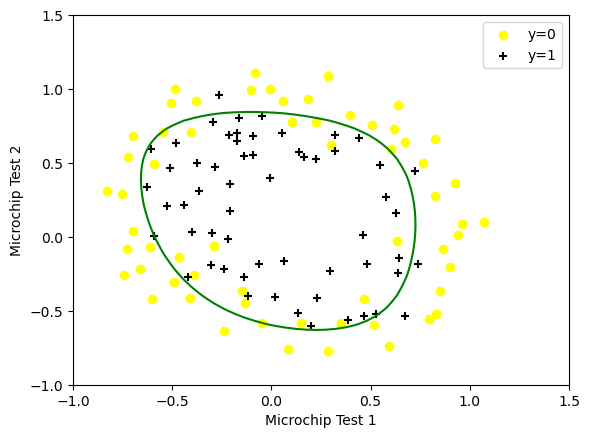

In [108]:
plot_decision_boundary(w, b, X_mapped, y_train)

plt.ylabel('Microchip Test 2')

plt.xlabel('Microchip Test 1')
plt.legend(loc="upper right")
plt.show()

In [106]:
# 使用predict函数在训练集上计算准确率
p = predict(X_mapped, w, b)

print(f"Train Accuracy: {np.mean(p == y_train) * 100}")  #  大概是 82%

Train Accuracy: 82.20338983050848
